# SVM

### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from joblib import dump, load

In [2]:
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [3]:
from preprocessing import reemplazarNulls,reemplazarCategoricas,reemplazarFechas,targetBooleano,regularizar,reemplazarCategoricas_OHE,reemplazarNullsNum,keepFeat_OHE

[###] Initial Preprocessings Done                           
[###] Aditional Preprocessings Done                                                   


In [4]:
from utilities import score, score2, df_feat, df_targ, train_val

### Codigo a correr

In [5]:
MAX_ITER = 10**6
MAX_JOBS = -1

**Run :** Entrenar Nuevamente o Cargar Entrenado

In [39]:
runLinearSimple = False
runLinear = False
runPoly = False
runRadial = False
runPolyOhe = False
runPolyOhe2 = True

**Save :** Guardar Modelo (pisa anterior)

In [40]:
saveLinear= False
saveLinearSimple= False
savePoly = False
saveRadial = False
savePolyOhe = False
savePolyOhe2 = True
saveBest = False

In [8]:
predictions = pd.DataFrame()

### Preprocesamiento

In [9]:
targetBooleano(df_targ, inplace=True)
ohe_feat = reemplazarCategoricas_OHE(df_feat)

reemplazarNulls(df_feat , inplace=True)
reemplazarCategoricas(df_feat , inplace=True)
reemplazarFechas(df_feat , inplace=True)
regularizar(df_feat , inplace=True)

reemplazarNullsNum(ohe_feat, inplace=True)
reemplazarFechas(ohe_feat , inplace=True)
ohe_feat2 = keepFeat_OHE(ohe_feat, 10)

In [10]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102356 entries, 74816 to 32535
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   direccion_viento_tarde       102356 non-null  float64
 1   direccion_viento_temprano    102356 non-null  float64
 2   horas_de_sol                 102356 non-null  float64
 3   humedad_tarde                102356 non-null  float64
 4   humedad_temprano             102356 non-null  float64
 5   mm_lluvia_dia                102356 non-null  float64
 6   nubosidad_tarde              102356 non-null  float64
 7   presion_atmosferica_tarde    102356 non-null  float64
 8   rafaga_viento_max_direccion  102356 non-null  float64
 9   rafaga_viento_max_velocidad  102356 non-null  float64
 10  velocidad_viendo_tarde       102356 non-null  float64
dtypes: float64(11)
memory usage: 9.4 MB


In [11]:
train_feat, val_feat, train_targ, val_targ = train_val( df_feat, df_targ, True )
train_feat2, val_feat2, train_targ2, val_targ2 = train_val( ohe_feat, df_targ, True )
train_feat3, val_feat3, train_targ3, val_targ3 = train_val( ohe_feat2, df_targ, True )

## Entrenamiento

### Lineal

#### Simple

In [12]:
if (runLinearSimple):
    svm_simple_lineal = SVC(
        kernel='linear', C=0.1,
        max_iter=MAX_ITER, shrinking=False, verbose = 1, probability=True,
    )
    svm_simple_lineal.fit( train_feat, train_targ )
    
    # Guardar
    if(saveLinearSimple):
        dump(svm_simple_lineal, 'models/SVM/svm_simple_lineal.sk') 
else:
    # Cargar
    svm_simple_lineal = load('models/SVM/svm_simple_lineal.sk')

AUC-ROC: 0.8475399723241047
              precision    recall  f1-score   support

       False       0.85      0.96      0.90      7946
        True       0.73      0.41      0.53      2290

    accuracy                           0.83     10236
   macro avg       0.79      0.68      0.71     10236
weighted avg       0.82      0.83      0.82     10236

CONFUSION MATRIX
CPU times: user 15.8 s, sys: 99.8 ms, total: 15.9 s
Wall time: 16 s


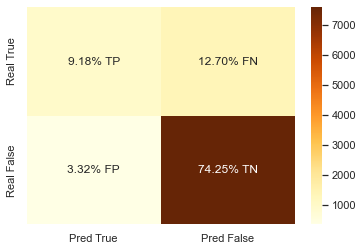

In [13]:
%%time
pred = svm_simple_lineal.predict(val_feat)
prob = svm_simple_lineal.predict_proba(val_feat)
score(val_targ, pred, prob[:,1])

In [14]:
pdf = score2('Lineal (Simple)','Regularizado',val_targ, pred, prob[:,1])
predictions = predictions.append( pdf )

#### Optimizando Hiperparametros

In [15]:
base_arrange = np.arange(0.01, 0.09, 0.03)
hipr_arrange = np.concatenate((base_arrange,base_arrange*10,base_arrange*100),axis=None)
hipr_arrange

array([0.01, 0.04, 0.07, 0.1 , 0.4 , 0.7 , 1.  , 4.  , 7.  ])

In [16]:
if (runLinear):
    svm_lineal = SVC(
        kernel='linear',
        max_iter=MAX_ITER, shrinking=False, probability=True,
    )
    params = {'C': hipr_arrange}
    
    svm_lineal_grid = HalvingGridSearchCV(
        svm_lineal,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=2, cv=2,
    ).fit(train_feat, train_targ)
    
    # Guardar
    if(saveLinear):
        dump(svm_lineal_grid, 'models/SVM/svm_lineal_grid.sk')
else:
    # Cargar
    svm_lineal_grid = load('models/SVM/svm_lineal_grid.sk')

In [17]:
print(f"Best score: {svm_lineal_grid.best_score_}")
print(f"Best params {svm_lineal_grid.best_params_}")

Best score: 0.8529340701093246
Best params {'C': 0.01}


In [18]:
svm_lineal = svm_lineal_grid.best_estimator_

AUC-ROC: 0.8475881138734495
              precision    recall  f1-score   support

       False       0.85      0.96      0.90      7946
        True       0.73      0.41      0.53      2290

    accuracy                           0.83     10236
   macro avg       0.79      0.68      0.71     10236
weighted avg       0.82      0.83      0.82     10236

CONFUSION MATRIX
CPU times: user 15.7 s, sys: 103 ms, total: 15.8 s
Wall time: 15.9 s


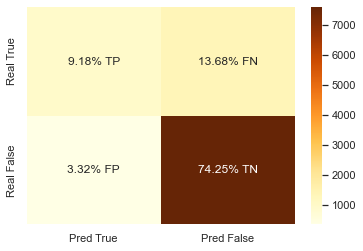

In [19]:
%%time
pred = svm_lineal.predict(val_feat)
prob = svm_lineal.predict_proba(val_feat)
score(val_targ, pred, prob[:,1])

In [20]:
pdf = score2('Lineal','Regularizado',val_targ, pred, prob[:,1])
predictions = predictions.append( pdf )

### Poly

In [21]:
if (runPolyOhe):
    svm_poly = SVC(
        kernel='poly',
        max_iter=MAX_ITER*10, shrinking=False, probability=True,
    )
    params = {
        'C': hipr_arrange*10,
        'degree': np.arange(1,5,1),
        'gamma': hipr_arrange,
        'coef0': hipr_arrange*10,
    }
    
    svm_poly_grid = HalvingGridSearchCV(
        svm_poly,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1, cv=2,
    ).fit(train_feat, train_targ)
    
    # Guardar
    if(savePolyOhe):
        dump(svm_poly_grid, 'models/SVM/svm_poly_grid.sk')
else:
    # Cargar
    svm_poly_grid = load('models/SVM/svm_poly_grid.sk')

In [22]:
print(f"Best score: {svm_poly_grid.best_score_}")
print(f"Best params {svm_poly_grid.best_params_}")

Best score: 0.8544879466592524
Best params {'C': 0.4, 'coef0': 1.0, 'degree': 2, 'gamma': 0.01}


In [23]:
svm_poly = svm_poly_grid.best_estimator_

AUC-ROC: 0.849826173834958
              precision    recall  f1-score   support

       False       0.84      0.97      0.90      7946
        True       0.77      0.38      0.51      2290

    accuracy                           0.84     10236
   macro avg       0.81      0.67      0.70     10236
weighted avg       0.83      0.84      0.81     10236

CONFUSION MATRIX
CPU times: user 17.4 s, sys: 120 ms, total: 17.5 s
Wall time: 17.7 s


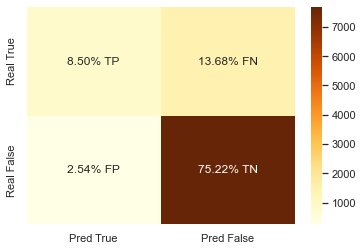

In [24]:
%%time
pred = svm_poly.predict(val_feat)
prob = svm_poly.predict_proba(val_feat)
score(val_targ, pred, prob[:,1])

In [25]:
pdf = score2('Poly','Regularizado',val_targ, pred, prob[:,1])
predictions = predictions.append( pdf )

#### One Hot Encoding

In [26]:
if (runPolyOhe):
    svm_poly_ohe = SVC(
        kernel='poly',
        max_iter=MAX_ITER*10, shrinking=False, probability=True,
    )
    params = {
        'C': hipr_arrange*10,
        'degree': np.arange(1,5,1),
        'gamma': hipr_arrange,
        'coef0': hipr_arrange*10,
    }
    
    svm_poly_ohe_grid = HalvingGridSearchCV(
        svm_poly_ohe,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1, cv=2,
    ).fit(train_feat2, train_targ2)
    
    # Guardar
    if(savePolyOhe):
        dump(svm_poly_ohe_grid, 'models/SVM/svm_poly_ohe_grid.sk')
else:
    # Cargar
    svm_poly_ohe_grid = load('models/SVM/svm_poly_ohe_grid.sk')

In [27]:
print(f"Best score: {svm_poly_ohe_grid.best_score_}")
print(f"Best params {svm_poly_ohe_grid.best_params_}")

Best score: 0.8709715751563119
Best params {'C': 0.7, 'coef0': 69.99999999999999, 'degree': 1, 'gamma': 0.01}


In [28]:
svm_poly_ohe = svm_poly_ohe_grid.best_estimator_

AUC-ROC: 0.8677241687064541
              precision    recall  f1-score   support

       False       0.86      0.95      0.90      7946
        True       0.74      0.46      0.57      2290

    accuracy                           0.84     10236
   macro avg       0.80      0.71      0.74     10236
weighted avg       0.83      0.84      0.83     10236

CONFUSION MATRIX
CPU times: user 47.2 s, sys: 277 ms, total: 47.5 s
Wall time: 47.9 s


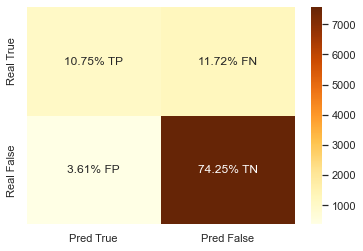

In [29]:
%%time
pred = svm_poly_ohe.predict(val_feat2)
prob = svm_poly_ohe.predict_proba(val_feat2)
score(val_targ2, pred, prob[:,1])

In [30]:
pdf = score2('Poly 2','OHE',val_targ2, pred, prob[:,1])
predictions = predictions.append( pdf )

#### One Hot Encoding con seleccion de variables

In [ ]:
if (runPolyOhe2):
    svm_poly_ohe2 = SVC(
        kernel='poly',
        max_iter=MAX_ITER*10, shrinking=False, probability=True,
    )
    params = {
        'C': hipr_arrange*10,
        'degree': np.arange(1,5,1),
        'gamma': hipr_arrange,
        'coef0': hipr_arrange*10,
    }
    
    svm_poly_ohe_grid2 = HalvingGridSearchCV(
        svm_poly_ohe2,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1, cv=2,
    ).fit(train_feat3, train_targ3)
    
    # Guardar
    if(savePolyOhe2):
        dump(svm_poly_ohe_grid2, 'models/SVM/svm_poly_ohe_grid2.sk')
else:
    # Cargar
    svm_poly_ohe_grid2 = load('models/SVM/svm_poly_ohe_grid2.sk')

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 42
max_resources_: 92120
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2916
n_resources: 42
Fitting 2 folds for each of 2916 candidates, totalling 5832 fits
----------
iter: 1
n_candidates: 972
n_resources: 126
Fitting 2 folds for each of 972 candidates, totalling 1944 fits


/Users/nicozulaica/Documents/FIUBA/orga/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/nicozulaica/Documents/FIUBA/orga/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


----------
iter: 2
n_candidates: 324
n_resources: 378
Fitting 2 folds for each of 324 candidates, totalling 648 fits


/Users/nicozulaica/Documents/FIUBA/orga/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/nicozulaica/Documents/FIUBA/orga/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


----------
iter: 3
n_candidates: 108
n_resources: 1134
Fitting 2 folds for each of 108 candidates, totalling 216 fits
----------
iter: 4
n_candidates: 36
n_resources: 3402
Fitting 2 folds for each of 36 candidates, totalling 72 fits
----------
iter: 5
n_candidates: 12
n_resources: 10206
Fitting 2 folds for each of 12 candidates, totalling 24 fits


/Users/nicozulaica/Documents/FIUBA/orga/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


----------
iter: 6
n_candidates: 4
n_resources: 30618
Fitting 2 folds for each of 4 candidates, totalling 8 fits
----------
iter: 7
n_candidates: 2
n_resources: 91854
Fitting 2 folds for each of 2 candidates, totalling 4 fits


In [ ]:
print(f"Best score: {svm_poly_ohe_grid2.best_score_}")
print(f"Best params {svm_poly_ohe_grid2.best_params_}")

In [ ]:
svm_poly_ohe2 = svm_poly_ohe_grid2.best_estimator_

In [ ]:
%%time
pred = svm_poly_ohe2.predict(val_feat3)
prob = svm_poly_ohe2.predict_proba(val_feat3)
score(val_targ3, pred, prob[:,1])

In [ ]:
pdf = score2('Poly 3','OHE 2',val_targ3, pred, prob[:,1])
predictions = predictions.append( pdf )

### Radial

In [ ]:
if (runRadial):
    svm_radial = SVC(
        kernel='rbf',
        max_iter=MAX_ITER, shrinking=False, probability=True,
    )
    params = {
        'C': hipr_arrange,
        'gamma': hipr_arrange,
    }
    
    svm_radial_grid = HalvingGridSearchCV(
        svm_radial,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1, cv=2,
    ).fit(train_feat, train_targ)
    
    # Guardar
    if(saveRadial):
        dump(svm_radial_grid, 'models/SVM/svm_radial_grid.sk')
else:
    # Cargar
    svm_radial_grid = load('models/SVM/svm_radial_grid.sk')

In [ ]:
print(f"Best score: {svm_radial_grid.best_score_}")
print(f"Best params {svm_radial_grid.best_params_}")

In [ ]:
svm_radial = svm_radial_grid.best_estimator_

In [ ]:
%%time
pred = svm_radial.predict(val_feat)
prob = svm_radial.predict_proba(val_feat)
score(val_targ, pred, prob[:,1])

In [ ]:
pdf = score2('Radial','Regularizado',val_targ, pred, prob[:,1])
predictions = predictions.append( pdf )

## Resultados

In [ ]:
predictions

In [ ]:
if(saveBest):
    dump(svm_poly_ohe, 'models/SVM/svm.sk')